## Train Models

### Train a logistic regression model with the engineered features

Including LDA-based topic similarity, sentence position, sentence length, and readability metrics, I trained a logistic regression model that can be applied to new sentences to predict whether they should be highlighted or not. I used logistic regression because this is a binary classification problem and because features weights can later be inspected to get an idea of their importance.

I also tested a couple of methods (synthetic oversampling [SMOTE] and undersampling) from the imblearn library to account for the imbalanced dataset (~2% highlighted vs ~98% non-highlighted sentences). These gave similar highlight sensitivity results and slightly more balanced precision and f1-scores than the logistic regression with sklearn's automatic class weight rebalancing.

Finally, I tested a random forest model for classification. This approach led to the non-highlighted samples dominating the prediction (despite balancing class weights in sklearn), such that highlight recall was very low. 

Thus, the final model that is applied in the backend of the **skimr** web app is a logistic regression model.



In [2]:
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob, Word
import pandas as pd
import sklearn
import pickle
import numpy as np
import scipy
from scipy import spatial
import nltk.data
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve, GridSearchCV, StratifiedKFold, cross_val_score, train_test_split 
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
from nltk.tokenize import RegexpTokenizer
word_tokenizer = RegexpTokenizer('\s+', gaps=True)
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

from stop_words import get_stop_words
stop_en = get_stop_words('en')

from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

en_words = set(nltk.corpus.words.words())

from gensim import corpora, models
import gensim

import timeit
import re
import string
from string import whitespace, punctuation

from nltk.corpus import stopwords
stopw_en = stopwords.words('english')
all_stopw = set(stopw_en) | set(stop_en)
print(len(all_stopw))


207


In [2]:
import math

from utils import get_char_count
from utils import get_words
from utils import get_sentences
from utils import count_syllables
from utils import count_complex_words


class Readability:
    analyzedVars = {}

    def __init__(self, text):
        self.analyze_text(text)

    def analyze_text(self, text):
        words = get_words(text)
        char_count = get_char_count(words)
        word_count = len(words)
        sentence_count = len(get_sentences(text))
        syllable_count = count_syllables(words)
        complexwords_count = count_complex_words(text)
        avg_words_p_sentence = word_count/sentence_count
        
        self.analyzedVars = {
            'words': words,
            'char_cnt': float(char_count),
            'word_cnt': float(word_count),
            'sentence_cnt': float(sentence_count),
            'syllable_cnt': float(syllable_count),
            'complex_word_cnt': float(complexwords_count),
            'avg_words_p_sentence': float(avg_words_p_sentence)
        }

    def ARI(self):
        score = 0.0 
        if self.analyzedVars['word_cnt'] > 0.0:
            score = 4.71 * (self.analyzedVars['char_cnt'] / self.analyzedVars['word_cnt']) + 0.5 * (self.analyzedVars['word_cnt'] / self.analyzedVars['sentence_cnt']) - 21.43
        return score
        
    def FleschReadingEase(self):
        score = 0.0 
        if self.analyzedVars['word_cnt'] > 0.0:
            score = 206.835 - (1.015 * (self.analyzedVars['avg_words_p_sentence'])) - (84.6 * (self.analyzedVars['syllable_cnt']/ self.analyzedVars['word_cnt']))
        return round(score, 4)
        
    def FleschKincaidGradeLevel(self):
        score = 0.0 
        if self.analyzedVars['word_cnt'] > 0.0:
            score = 0.39 * (self.analyzedVars['avg_words_p_sentence']) + 11.8 * (self.analyzedVars['syllable_cnt']/ self.analyzedVars['word_cnt']) - 15.59
        return round(score, 4)
        
    def GunningFogIndex(self):
        score = 0.0 
        if self.analyzedVars['word_cnt'] > 0.0:
            score = 0.4 * ((self.analyzedVars['avg_words_p_sentence']) + (100 * (self.analyzedVars['complex_word_cnt']/self.analyzedVars['word_cnt'])))
        return round(score, 4)

    def SMOGIndex(self):
        score = 0.0 
        if self.analyzedVars['word_cnt'] > 0.0:
            score = (math.sqrt(self.analyzedVars['complex_word_cnt']*(30/self.analyzedVars['sentence_cnt'])) + 3)
        return score

    def ColemanLiauIndex(self):
        score = 0.0 
        if self.analyzedVars['word_cnt'] > 0.0:
            score = (5.89*(self.analyzedVars['char_cnt']/self.analyzedVars['word_cnt']))-(30*(self.analyzedVars['sentence_cnt']/self.analyzedVars['word_cnt']))-15.8
        return round(score, 4)

    def LIX(self):
        longwords = 0.0
        score = 0.0 
        if self.analyzedVars['word_cnt'] > 0.0:
            for word in self.analyzedVars['words']:
                if len(word) >= 7:
                    longwords += 1.0
            score = self.analyzedVars['word_cnt'] / self.analyzedVars['sentence_cnt'] + float(100 * longwords) / self.analyzedVars['word_cnt']
        return score

    def RIX(self):
        longwords = 0.0
        score = 0.0 
        if self.analyzedVars['word_cnt'] > 0.0:
            for word in self.analyzedVars['words']:
                if len(word) >= 7:
                    longwords += 1.0
            score = longwords / self.analyzedVars['sentence_cnt']
        return score

if __name__ == "__main__":
    text = """We are close to wrapping up our 10 week Rails Course. This week we will cover a handful of topics commonly encountered in Rails projects. We then wrap up with part 2 of our Reddit on Rails exercise!  By now you should be hard at work on your personal projects. The students in the course just presented in front of the class with some live demos and a brief intro to to the problems their app were solving. Maybe set aside some time this week to show someone your progress, block off 5 minutes and describe what goal you are working towards, the current state of the project (is it almost done, just getting started, needs UI, etc.), and then show them a quick demo of the app. Explain what type of feedback you are looking for (conceptual, design, usability, etc.) and see what they have to say.  As we are wrapping up the course you need to be focused on learning as much as you can, but also making sure you have the tools to succeed after the class is over."""

    rd = Readability(text)

In [3]:
# testing readability
rd = Readability('We are close to wrapping up our 10 week Rails Course. This week we will cover a handful of topics commonly encountered in Rails projects. We then wrap up with part 2 of our Reddit on Rails exercise!  By now you should be hard at work on your personal projects. The students in the course just presented in front of the class with some live demos and a brief intro to to the problems their app were solving. Maybe set aside some time this week to show someone your progress, block off 5 minutes and describe what goal you are working towards, the current state of the project (is it almost done, just getting started, needs UI, etc.), and then show them a quick demo of the app. Explain what type of feedback you are looking for (conceptual, design, usability, etc.) and see what they have to say.  As we are wrapping up the course you need to be focused on learning as much as you can, but also making sure you have the tools to succeed after the class is over.')
print(rd.ARI())

7.216451612903228


### Load dictionary and data

In [11]:
# dict_all = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/dict_all_new','rb'))
# data = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/data_pd_new')
# data.head()


### CONVERT list of paragraphs in 'text' column into string containing all text


In [ ]:
set_tr = data

n = 0
sent_join = []
for i in set_tr['text']:
    sent = str(' '.join(i))
    sent_join.append(sent)





### DELETE HIGHLIGHTS FROM FULLTEXT SENTENCES


In [ ]:
n = 0
fulls_noh = []
for i in set_tr['highlights']:
    full = sent_join[n]
#     print(full)
#     print(i)
    full_noh = full.replace(i,'.')
#     print(full_noh)
    fulls_noh.append(full_noh)
    n+=1
set_tmp = set_tr
set_tr = pd.DataFrame({'ids':set_tmp['ids'], 'highlights':set_tmp['highlights'], 'text':set_tmp['text'], 'textwohighlight':fulls_noh})

print(len(set_tr['textwohighlight']))





### Save set_tr

In [ ]:

# fset_tr = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/set_tr','wb')
# pickle.dump(set_tr, fset_tr)


### LOAD set_tr


In [7]:
set_tr = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/set_tr')
print(set_tr)


                                             highlights   ids  \
0     Until you appreciate what you currently have, ...     2   
1     And let’s not feel terrified, but full of rene...     4   
2     Hard work is doing the work other people don’t...     5   
3     He’d made up his mind to skip the dog thing al...    10   
4     Realizing that our actions, feelings and behav...    12   
5     So, the advice I have is to find what your nor...    13   
6     Cryptoeconomic approaches combine cryptography...    14   
7     You can feel however you want about Durant’s d...    15   
8      A good principle should be a tradeoff, a choice.    16   
9     But do I think there are going to be 12 people...    17   
10    Angry, unhappy people demand bad leaders, who ...    18   
11    For clarity we remove technical terms and we p...    19   
12    The fact that something takes longer and requi...    22   
13    Prioritize placing buttons at the bottom of th...    23   
14    Token networks remo

### Create 'dataset' for further analysis (and pickle)

In [38]:

dataset = pd.DataFrame({'highlights':set_tr['highlights'], 'ids':set_tr['ids'], 'text':set_tr['text'], \
                        'textwohighlight':fulls_noh, 'textjoined':sent_join})
print(dataset)

dataset.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/dataset_hl_ids_txt_wohl_joined')

                                             highlights   ids  \
0     Until you appreciate what you currently have, ...     2   
1     And let’s not feel terrified, but full of rene...     4   
2     Hard work is doing the work other people don’t...     5   
3     He’d made up his mind to skip the dog thing al...    10   
4     Realizing that our actions, feelings and behav...    12   
5     So, the advice I have is to find what your nor...    13   
6     Cryptoeconomic approaches combine cryptography...    14   
7     You can feel however you want about Durant’s d...    15   
8      A good principle should be a tradeoff, a choice.    16   
9     But do I think there are going to be 12 people...    17   
10    Angry, unhappy people demand bad leaders, who ...    18   
11    For clarity we remove technical terms and we p...    19   
12    The fact that something takes longer and requi...    22   
13    Prioritize placing buttons at the bottom of th...    23   
14    Token networks remo

### LOAD LDA vectors for articles



In [10]:
ldamodel = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/lda_10topic20pass','rb'))
print(ldamodel.print_topics( num_topics=10, num_words=5))

all_lda_vecs = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/all_lda_vecs','rb'))
print(all_lda_vecs[0])

commonwords_2 = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/commonwords2','rb'))
# wordlist = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/wordlist','rb')

dictionary = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/lda_dictionary_new2','rb'))
print(dictionary)

[(0, '0.011*"compani" + 0.010*"product" + 0.008*"busi" + 0.007*"build" + 0.007*"team"'), (1, '0.030*"design" + 0.010*"user" + 0.007*"code" + 0.006*"web" + 0.006*"color"'), (2, '0.013*"write" + 0.013*"read" + 0.008*"learn" + 0.008*"love" + 0.007*"life"'), (3, '0.034*"via" + 0.028*"music" + 0.025*"game" + 0.020*"univ" + 0.019*"data"'), (4, '0.007*"us" + 0.006*"learn" + 0.006*"world" + 0.005*"system" + 0.005*"human"'), (5, '0.153*"de" + 0.103*"e" + 0.044*"um" + 0.040*"da" + 0.039*"para"'), (6, '0.055*"white" + 0.033*"black" + 0.016*"photo" + 0.016*"hou" + 0.016*"presid"'), (7, '0.016*"life" + 0.008*"success" + 0.007*"feel" + 0.007*"becom" + 0.006*"learn"'), (8, '0.009*"food" + 0.007*"home" + 0.006*"eat" + 0.006*"hou" + 0.006*"live"'), (9, '0.007*"trump" + 0.007*"us" + 0.007*"said" + 0.005*"men" + 0.005*"never"')]
[0.10107509328751951, 0, 0.10852728610649451, 0, 0.075517989451679202, 0, 0, 0.67870291423836493, 0, 0.022212525354884893]
Dictionary(17433 unique tokens: ['give', 'success', 'wa

### Convert lda topic tuple output to a vector



In [8]:
def lda_to_vec(lda_input):
    num_topics = 10
    vec = [0]*num_topics
    for i in lda_input:
        col = i[0]
        val = i[1]
        vec[col] = val
    return vec

### Clean text for LDA



In [9]:
def clean_text(sent):
    # remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    txt2 = re.sub(u'\u2014','',sent) # remove em dashes
    txt3 = re.sub(r'\d+', '', txt2) # remove digits
    txt4 = txt3.translate(translator) # remove punctuation
    # split text into words
    tokens = word_tokenizer.tokenize(txt4.lower())
    # strip single and double quotes from ends of words
    tokens_strip = [i.strip('”“’‘') for i in tokens]
    # keep only english words
    tokens_en = [i for i in tokens_strip if i in en_words]
    # remove nltk/stop_word stop words
    nostop_tokens = [i for i in tokens_en if not i in all_stopw]
    # strip single and double quotes from ends of words
    nostop_strip = [i.strip('”“’‘') for i in nostop_tokens]
    # stem words
    stemmed = [p_stemmer.stem(i) for i in nostop_strip]
    # strip single and double quotes from ends of words
    stemmed_strip = [i.strip('”“’‘') for i in stemmed]
    # stem words
    stemmed2 = [p_stemmer.stem(i) for i in stemmed_strip]
    # strip single and double quotes from ends of words
    stemmed2_strip = [i.strip('”“’‘') for i in stemmed2]
    # remove common words post-stemming
    stemmed_nocommon = [i for i in stemmed2_strip if not i in commonwords_2]
    return stemmed_nocommon



### test if all highlights are in main texts



In [ ]:
# for h in dataset['highlights']:
    

#     # sentence is tokenized from highlight or full text
    
#     # break text into sentences and get total sents in full text
#     full_sents = sent_tokenizer.tokenize(text)
#     num_sents = len(full_sents)

#     # break text into words and get total words in full text
#     full_words = word_tokenizer.tokenize(text)
#     num_words = len(full_words)

#     try:
#         pos = text.index(sentence)

#         # total words in full text before highlight position
#         b4_words = word_tokenizer.tokenize(text[:pos])
#         b4_wlen = len(b4_words)

#         # sentences in full text before highlight position
#         b4_sents = sent_tokenizer.tokenize(text[:pos])
#         b4_slen = len(b4_sents)

#         frc_w = b4_wlen / num_words
#         frc_s = b4_slen / num_sents
#     except ValueError:
#         print('\nsentence not in text!\n')
    
#     return frc_w, frc_s


### Function to calculate position of sentence within article (frac of sentences into text)



In [29]:
def sent_pos(sentence, text, idval):

    # sentence is tokenized from highlight or full text
    
    # remove 1-word sentences?
    
    # break text into sentences and get total sents in full text
    full_sents = sent_tokenizer.tokenize(text)
    num_sents = len(full_sents)

    # break text into words and get total words in full text
    full_words = word_tokenizer.tokenize(text)
    num_words = len(full_words)

#     try:
    pos = text.find(sentence)

    if pos >= 0:

        # total words in full text before highlight position
        b4_words = word_tokenizer.tokenize(text[:pos])
        b4_wlen = len(b4_words)

        # sentences in full text before highlight position
        b4_sents = sent_tokenizer.tokenize(text[:pos])
        b4_slen = len(b4_sents)

        frc_w = b4_wlen / num_words
        frc_s = b4_slen / num_sents

    elif pos < 0:
#             print('\nsentence not in text!\n')
        print(str(idval) + ' ' + str(sentence))
        frc_w = -1
        frc_s = -1
            
#     except ValueError:
#         print('\nvalueerror: sentence not in text!\n')
    
    return frc_w, frc_s



### Calculate values for logistic regression features

for each id (corresponds to a highlight and a full-text), 
tokenize highlight into sentences
tokenize full-text w/o highlights into non-highlighted sentences

for each sentence in highlight and full-text, 
calculate:
  sentence length
  readability (various)
  LDA vector of sentence -> cos similarity to LDA vector of article
put in array:
  id     sentence length     readability (various)     LDA similarity

*NOTE: Calculated some features at a time by commenting out the appropriate lines below; this is why there are separate pickle files for different sets of feature calculations. Not critical, because all features are combined into one dataframe downstream anyway.*


In [72]:
tic = timeit.default_timer()

# print(set_tr.head(10))
n = 0

articleids = []
hlorno = []

all_ARI = []
all_FRE = []
all_FKG = []
all_GFI = []
all_SMG = []
all_CLI = []
all_LIX = []
all_RIX = []
alllens = []
all_ldadists = []
all_wposes = []
all_sposes = []

h_ARI = []
h_FRE = []
h_FKG = []
h_GFI = []
h_SMG = []
h_CLI = []
h_LIX = []
h_RIX = []
hllens = []
h_ldadists = []
h_wposes = []
h_sposes = []

f_ARI = []
f_FRE = []
f_FKG = []
f_GFI = []
f_SMG = []
f_CLI = []
f_LIX = []
f_RIX = []
ftlens = []
f_ldadists = []
f_wposes = []
f_sposes = []

for i, row in dataset.iterrows():

    idval = row.ids
    if i%10 == 0:
        print('analyzing row: '+str(i)+' ')
    # Get topic vector for the whole article
    lda_art = all_lda_vecs[i]
#     lda_art = np.asarray(all_lda_vecs[i])
#     print(lda_art)
    
    hlsents = sent_tokenizer.tokenize(row.highlights)
    for h in hlsents:
        # 
        # get LDA metric
        h_clean = clean_text(h)
        h_corpus = dictionary.doc2bow(h_clean)
        sent_lda = ldamodel[h_corpus]
        vec_lda = lda_to_vec(sent_lda)
        h_lda = 1-spatial.distance.cosine(vec_lda, lda_art)
        np_vec_lda = np.asarray(vec_lda)
        h_ldadists.append(h_lda)
        all_ldadists.append(h_lda)
        
        # get fraction position
        h_wpos, h_spos = sent_pos(h, row.textjoined, idval)
#         if n <= 5:
#             print('wordpos: '+str(h_wpos))
#             print('sentpos: '+str(h_spos))
        h_wposes.append( float(h_wpos) )
        h_sposes.append( float(h_spos) )
        all_wposes.append( float(h_wpos) )
        all_sposes.append( float(h_spos) )
        
        # get length
        hlwords = word_tokenizer.tokenize(h)
        hllen = len(hlwords)
        hllens.append(int(hllen))
        alllens.append(int(hllen))

        # get readability
        h_rd = Readability(h)
        h_ARI.append( float(h_rd.ARI()) )
        h_FRE.append( float(h_rd.FleschReadingEase()) )
        h_FKG.append( float(h_rd.FleschKincaidGradeLevel()) )
        h_GFI.append( float(h_rd.GunningFogIndex()) )
        h_SMG.append( float(h_rd.SMOGIndex()) )
        h_CLI.append( float(h_rd.ColemanLiauIndex()) )
        h_LIX.append( float(h_rd.LIX()) )
        h_RIX.append( float(h_rd.RIX()) )
        all_ARI.append( float(h_rd.ARI()) )
        all_FRE.append( float(h_rd.FleschReadingEase()) )
        all_FKG.append( float(h_rd.FleschKincaidGradeLevel()) )
        all_GFI.append( float(h_rd.GunningFogIndex()) )
        all_SMG.append( float(h_rd.SMOGIndex()) )
        all_CLI.append( float(h_rd.ColemanLiauIndex()) )
        all_LIX.append( float(h_rd.LIX()) )
        all_RIX.append( float(h_rd.RIX()) )

        # get label and id
        articleids.append(int(i))
        hlorno.append(1)

    # count lengths of non-highlighted sentences
    ftsents = sent_tokenizer.tokenize(row.textwohighlight)
    for f in ftsents:
        # get LDA metric
        f_clean = clean_text(f)
        f_corpus = dictionary.doc2bow(f_clean)
        sent_lda = ldamodel[f_corpus]
        vec_lda = lda_to_vec(sent_lda)
        f_lda = 1-spatial.distance.cosine(vec_lda, lda_art)
        np_vec_lda = np.asarray(vec_lda)
        f_ldadists.append(f_lda)
        all_ldadists.append(f_lda)

        # get fraction position
        f_wpos, f_spos = sent_pos(f[:-2], row.textjoined, idval)
#         if n <= 5:
#             print('wordpos: '+str(f_wpos))
#             print('sentpos: '+str(f_spos))
        f_wposes.append( float(f_wpos) )
        f_sposes.append( float(f_spos) )
        all_wposes.append( float(f_wpos) )
        all_sposes.append( float(f_spos) )
        
        # get length
        ftwords = word_tokenizer.tokenize(f)
        ftlen = len(ftwords)
        ftlens.append(int(ftlen))
        alllens.append(int(ftlen))

        # get readability
        f_rd = Readability(f)
        f_ARI.append( float(f_rd.ARI()) )
        f_FRE.append( float(f_rd.FleschReadingEase()) )
        f_FKG.append( float(f_rd.FleschKincaidGradeLevel()) )
        f_GFI.append( float(f_rd.GunningFogIndex()) )
        f_SMG.append( float(f_rd.SMOGIndex()) )
        f_CLI.append( float(f_rd.ColemanLiauIndex()) )
        f_LIX.append( float(f_rd.LIX()) )
        f_RIX.append( float(f_rd.RIX()) )
        all_ARI.append( float(f_rd.ARI()) )
        all_FRE.append( float(f_rd.FleschReadingEase()) )
        all_FKG.append( float(f_rd.FleschKincaidGradeLevel()) )
        all_GFI.append( float(f_rd.GunningFogIndex()) )
        all_SMG.append( float(f_rd.SMOGIndex()) )
        all_CLI.append( float(f_rd.ColemanLiauIndex()) )
        all_LIX.append( float(f_rd.LIX()) )
        all_RIX.append( float(f_rd.RIX()) )

        # get label and id
        articleids.append(int(i))
        hlorno.append(0)
    
    n += 1
#     if n == 5:
#         break

# print(len(articleids))
# print(len(hlorno))
# print(len(alllens))
# print(len(all_rds))
# print(len(all_ldadists))
# print(len(hllens))
# print(len(ftlens))
# print(len(h_rds))
# print(len(f_rds))
# print(len(h_ldadists))
# print(len(f_ldadists))

toc = timeit.default_timer()
print(str(toc - tic) + ' seconds elapsed')


analyzing row: 0 
analyzing row: 10 
analyzing row: 20 
36 Or, as Bertrand Russell — who lived through the invention of electric lights, radio, and television — put it: “.” The Google office, crammed as it was with games and toys and dessert bars for grown-ups, was an unlikely alternativ
analyzing row: 30 
analyzing row: 40 
analyzing row: 50 
analyzing row: 60 
analyzing row: 70 
107 I spent several long weekends that winter at my parents’ house on Long Island, dragging garbage cans to a dumpster parked in the yard — ., and my mother required help distinguishing the one from the othe
analyzing row: 80 
analyzing row: 90 
124 This is because .. You can read more on this in Harry Robert’s article, Single-direction margin declaration
analyzing row: 100 
144 Once you have those things ., designing the product becomes a lot easie
analyzing row: 110 
164 .. Bottom line: you want to keep goin
analyzing row: 120 
analyzing row: 130 
analyzing row: 140 
212 But enough preamble, here’s how this

In [73]:
# # time required for position + readability analysis:
# # 2985.0007762390014 seconds elapsed
# # 2746.6176740369992 seconds elapsed for just position

# # count number of sentences excluded from position analysis
# print(h_wposes.count(-1))
# print(h_sposes.count(-1))
# print(f_wposes.count(-1))
# print(f_sposes.count(-1))
# print(all_wposes.count(-1))
# print(all_sposes.count(-1))

0
0
143
143
143
143


In [75]:
# time required for length + LDA analysis:
# 398.4295387339953 seconds elapsed


281331


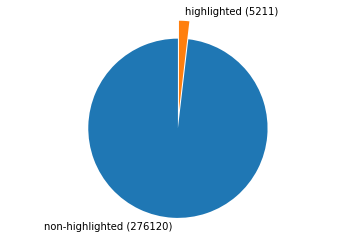

In [54]:
plt.pie([276120,5211], explode=(0,0.2), labels=['non-highlighted (276120)','highlighted (5211)'], shadow=False, startangle=90)
plt.axis('equal')
plt.show()


In [76]:
analyzed_data_h = pd.DataFrame({ \
'h_wposes':h_wposes, \
'h_sposes':h_sposes, \
'h_ARI':h_ARI, \
'h_FRE':h_FRE, \
'h_FKG':h_FKG, \
'h_GFI':h_GFI, \
'h_SMG':h_SMG, \
'h_CLI':h_CLI, \
'h_LIX':h_LIX, \
'h_RIX':h_RIX, \
})

analyzed_data_all = pd.DataFrame({ \
'all_wposes':all_wposes, \
'all_sposes':all_sposes, \
'all_ARI':all_ARI, \
'all_FRE':all_FRE, \
'all_FKG':all_FKG, \
'all_GFI':all_GFI, \
'all_SMG':all_SMG, \
'all_CLI':all_CLI, \
'all_LIX':all_LIX, \
'all_RIX':all_RIX, \
})

analyzed_data_f = pd.DataFrame({ \
'f_wposes':f_wposes, \
'f_sposes':f_sposes, \
'f_ARI':f_ARI, \
'f_FRE':f_FRE, \
'f_FKG':f_FKG, \
'f_GFI':f_GFI, \
'f_SMG':f_SMG, \
'f_CLI':f_CLI, \
'f_LIX':f_LIX, \
'f_RIX':f_RIX, \
})

analyzed_data_h.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/analyzed_data_h')
analyzed_data_f.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/analyzed_data_f')
analyzed_data_all.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/analyzed_data_all')




### Save article ids and highlight-or-not label after analyzing for FRE and position (without length and LDA)


In [52]:
# articleids_w_FRE_pos_list = articleids
# hlorno_w_FRE_pos_list = hlorno

# articleids_w_FRE_pos = pd.DataFrame({'articleids':articleids_w_FRE_pos_list})
# hlorno_w_FRE_pos = pd.DataFrame({'hlorno':hlorno_w_FRE_pos_list})
# articleids_w_FRE_pos.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/articleids_w_FRE_pos')
# hlorno_w_FRE_pos.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/hlorno_w_FRE_pos')

### Save article ids and highlight-or-not label after analyzing for length and LDA


In [ ]:
# articleids_w_len_lda_list = articleids
# hlorno_w_len_lda_list = hlorno

# articleids_w_len_lda = pd.DataFrame({'articleids':articleids_w_len_lda_list})
# hlorno_w_len_lda = pd.DataFrame({'hlorno':hlorno_w_len_lda_list})
# articleids_w_len_lda.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/articleids_w_len_lda')
# hlorno_w_len_lda.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/hlorno_w_len_lda')

In [58]:
# print(articleids_w_len_lda_list == articleids_w_FRE_pos_list)
# print(hlorno_w_FRE_pos_list == hlorno_w_len_lda_list)

True
True


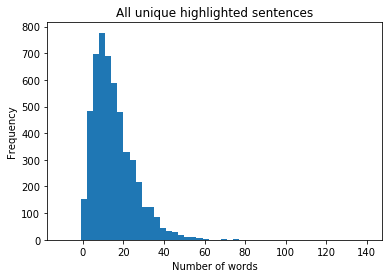

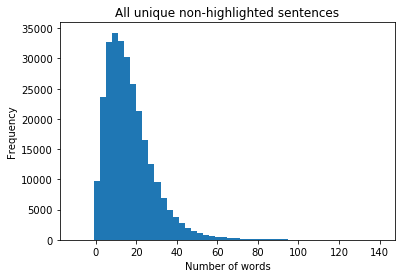

In [80]:
from statistics import mode

# print(max(hllens))
# print(scipy.stats.mode(hllens))
# print(max(ftlens))
# print(scipy.stats.mode(ftlens))

# print(max(h_rds))
# print(scipy.stats.mode(h_rds))
# print(max(f_rds))
# print(scipy.stats.mode(f_rds))


plt.hist(hllens, bins=50, range=(-10,140))
plt.title("All unique highlighted sentences")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

plt.hist(ftlens, bins=50, range=(-10,140))
plt.title("All unique non-highlighted sentences")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

# print(len(hllens))
# print(len(ftlens))
# print(len(alllens))



# plt.hist(h_ldadists, bins=50)#, normed=1)
# plt.title("All unique highlighted sentences")
# plt.xlabel("LDA distance")
# plt.ylabel("Frequency")
# plt.show()

# plt.hist(f_ldadists, bins=50)#, normed=1)
# plt.title("All unique non-highlighted sentences")
# plt.xlabel("LDA distance")
# plt.ylabel("Frequency")
# plt.show()

# print(len(h_ldadists))
# print(len(f_ldadists))
# print(len(all_ldadists))


# plt.hist(h_wposes, bins=25, range=(0,1), normed=1)
# plt.title("All unique highlighted sentences")
# plt.xlabel("Fraction words into full text")
# plt.ylabel("Frequency")
# plt.show()

# plt.hist(h_sposes, bins=25, range=(0,1), normed=1)
# plt.title("All unique highlighted sentences")
# plt.xlabel("Fraction sentences into full text")
# plt.ylabel("Frequency")
# plt.show()

# plt.hist(f_wposes, bins=25, range=(0,1), normed=1)
# plt.title("All unique non-highlighted sentences")
# plt.xlabel("Fraction words into full text")
# plt.ylabel("Frequency")
# plt.show()

# plt.hist(f_sposes, bins=25, range=(0,1), normed=1)
# plt.title("All unique non-highlighted sentences")
# plt.xlabel("Fraction sentences into full text")
# plt.ylabel("Frequency")
# plt.show()

# print(len(h_wposes))
# print(len(h_sposes))
# print(len(f_wposes))
# print(len(f_sposes))
# print(len(all_wposes))

# plt.hist(h_sposes, bins=25, range=(0,1), normed=1)
# plt.title("All unique highlighted sentences")
# plt.xlabel("Fraction sentences into full text")
# plt.ylabel("Frequency")
# plt.show()
# plt.hist(f_sposes, bins=25, range=(0,1), normed=1)
# plt.title("All unique non-highlighted sentences")
# plt.xlabel("Fraction sentences into full text")
# plt.ylabel("Frequency")
# plt.show()
# plt.hist(all_sposes, bins=25, range=(0,1), normed=1)
# plt.title("All unique sentences")
# plt.xlabel("Fraction sentences into full text")
# plt.ylabel("Frequency")
# plt.show()



### Put into pandas dataframe to submit to logistic regression



In [81]:
dataset_submit = pd.DataFrame({ \
'highlightornot':hlorno, \
'length':alllens, \
'LDAdist':all_ldadists, \
'wordPos':all_wposes, \
'sentPos':all_sposes, \
'ARI':all_ARI, \
'FRE':all_FRE, \
'FKG':all_FKG, \
'GFI':all_GFI, \
'SMG':all_SMG, \
'CLI':all_CLI, \
'LIX':all_LIX, \
'RIX':all_RIX, \
                             })
dataset_submit.to_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/dataset_submit_len_lda_wpos_wpos_readmets')

dataset_submit = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/dataset_submit_len_lda_wpos_wpos_readmets')

print(dataset_submit)

              ARI      CLI      FKG       FRE      GFI   LDAdist        LIX  \
0        8.620000  11.3423   7.6338   63.4862  11.3538  0.978843  28.384615   
1       14.007500  18.5125   7.7733   60.7050   8.1333  0.981704  28.666667   
2        7.295294   7.7276   6.3106   80.0976   9.1529  0.185355  40.529412   
3       -0.087273   1.2845   1.5727  103.3791   4.4000  0.980338  11.000000   
4        4.410000   5.6171   4.1986   89.8964   8.4571  0.978843  21.142857   
5        0.340000   2.4633  -4.2133  141.3000   8.0444  0.088626  20.111111   
6        3.338182   5.5682   2.6455   95.6882   4.4000  0.978844  20.090909   
7       16.609767   4.1858  14.3521   68.7528  19.0605  0.155225  52.302326   
8       -2.660000  -4.2033  -6.5533  147.3900   1.2000  0.445979   3.000000   
9        4.678947   3.3911   7.3463   76.2342  11.8105  0.172752  24.263158   
10       8.397368   8.0411   9.8305   58.4237  11.8105  0.976764  34.789474   
11      -0.090000   1.7600   2.8800   83.3200  10.00

### Describe statistical model with patsy

In [3]:
dataset_submit = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/dataset_submit_len_lda_wpos_wpos_readmets')

# create dataframe
y, X = dmatrices('highlightornot ~ length + LDAdist + wordPos + sentPos + ARI + FRE + FKG + GFI + SMG + CLI + LIX + RIX', \
                 dataset_submit, return_type="dataframe")
# ytest, Xtest = dmatrices('length ~ length + FRE', set_tr_submit, return_type="dataframe")
# print( Xtest.columns)
# print(ytest)

# flatten y into a 1-D array
y = np.ravel(y)

### Split into train and test sets


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)




In [180]:
file = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/Xtrain_len_lda_wpos_wpos_readmets','wb')
pickle.dump(X_train,file)
file = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/Xtest_len_lda_wpos_wpos_readmets','wb')
pickle.dump(X_test,file)
file = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/ytrain_len_lda_wpos_wpos_readmets','wb')
pickle.dump(y_train,file)
file = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/ytest_len_lda_wpos_wpos_readmets','wb')
pickle.dump(y_test,file)



### Include data preprocessing to scale all features! (i.e. calculate z-scores)


In [153]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', penalty='l2'))

# ## fit
# pipe.fit(X, y)
# ## predict
# pipe.predict_proba(X)
# ## to get back mean/std
# scaler = pipe.steps[0][1]
# scaler.mean_
# # Out[12]: array([ 0.0313, -0.0334,  0.0145, ..., -0.0247,  0.0191,  0.0439])
# scaler.std_
# # Out[13]: array([ 1.    ,  1.0553,  0.9805, ...,  1.0033,  1.0097,  0.9884])
    
    
# pipe = LogisticRegression(class_weight='balanced', penalty='l2')
pipe.fit(X_train, y_train)
# print(X_train)
print(len(y_train))
print(len(y_test))
print(len(X_train))
print(len(X_test))

225064
56267
225064
56267


### save/load model


In [3]:
# fpipe = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/model_len_lda_wpos_wpos_readmets','wb')
# pickle.dump(pipe, fpipe)

# load model
pipe = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/model_len_lda_wpos_wpos_readmets')
X_train = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/Xtrain_len_lda_wpos_wpos_readmets')
X_test = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/Xtest_len_lda_wpos_wpos_readmets')
y_train = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/ytrain_len_lda_wpos_wpos_readmets')
y_test = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/ytest_len_lda_wpos_wpos_readmets')



## Evaluate logistic regression model

In [4]:
# check the accuracy on the training set
pipe.score(X_train, y_train)

0.45945597696655172

In [5]:
# check the accuracy on the test set
pipe.score(X_test, y_test)

0.45785273783923081

In [6]:
# predict class labels for the test set
predicted = pipe.predict(X_test)
print(predicted)
test = np.nonzero(predicted)
print(len(test[0]))
print(len(predicted))

[ 1.  0.  1. ...,  1.  0.  1.]
30734
56267


### Examine feature weights (feature coefficients)


In [13]:
print(np.transpose(pipe.steps[1][1].coef_))
print(X_test.columns)
tmp = X_test.columns.name[2:]
print(tmp)
# [[ 0.        ]
#  [-0.75450588]
#  [ 0.00378554]
#  [-0.14955534]
#  [ 0.17832368]
#  [-0.06008622]
#  [ 0.69844673]
#  [ 1.1656712 ]
#  [ 0.01445301]
#  [ 0.10138341]
#  [ 0.12576411]
#  [ 0.16656827]
#  [-0.75734814]]
# Index(['Intercept', 'length', 'LDAdist', 'wordPos', 'sentPos', 'ARI', 'FRE',
#        'FKG', 'GFI', 'SMG', 'CLI', 'LIX', 'RIX'],
#       dtype='object')


# WHEN ONLY USE LOGISTIC REGRESSION (NO Z-SCORE PREPROCESSING)
# print(np.transpose(pipe.coef_))
# [[-0.83983031]
#  [-0.0366619 ]
#  [ 0.01134218]
#  [-0.49050534]
#  [ 0.59117833]
#  [-0.00489886]
#  [ 0.01644136]
#  [ 0.11783003]
#  [ 0.00142764]
#  [ 0.0216104 ]
#  [ 0.0138162 ]
#  [ 0.00623342]
#  [-0.09777468]]
# Index(['Intercept', 'length', 'LDAdist', 'wordPos', 'sentPos', 'ARI', 'FRE',
#        'FKG', 'GFI', 'SMG', 'CLI', 'LIX', 'RIX'],
#       dtype='object')

[[ 0.        ]
 [-0.75450588]
 [ 0.00378554]
 [-0.14955534]
 [ 0.17832368]
 [-0.06008622]
 [ 0.69844673]
 [ 1.1656712 ]
 [ 0.01445301]
 [ 0.10138341]
 [ 0.12576411]
 [ 0.16656827]
 [-0.75734814]]
Index(['Intercept', 'length', 'LDAdist', 'wordPos', 'sentPos', 'ARI', 'FRE',
       'FKG', 'GFI', 'SMG', 'CLI', 'LIX', 'RIX'],
      dtype='object')


TypeError: 'NoneType' object is not subscriptable

### ROC curve and evaluation metrics

In [7]:
# generate class probabilities
probs = pipe.predict_proba(X_test)
print (probs)

[[ 0.48381601  0.51618399]
 [ 0.65055944  0.34944056]
 [ 0.48048208  0.51951792]
 ..., 
 [ 0.4651526   0.5348474 ]
 [ 0.6783202   0.3216798 ]
 [ 0.48697564  0.51302436]]


In [8]:
# generate evaluation metrics
print( metrics.accuracy_score(y_test, predicted))
print( metrics.roc_auc_score(y_test, probs[:, 1]))

0.457852737839
0.55262283331


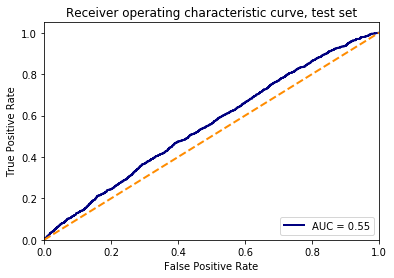

In [17]:
# plot ROC curve for test set

from sklearn.metrics import roc_curve, auc

auc_score = metrics.roc_auc_score(y_test, probs[:, 1])
fpr, tpr, thres = metrics.roc_curve(y_test, probs[:,1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='navy',
         lw=lw, label='AUC = %0.2f' % auc_score)
plt.plot([0, 1], [0, 1], color='darkorange', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve, test set')
plt.legend(loc="lower right")
plt.show()


[[ 0.51904363  0.48095637]
 [ 0.44721335  0.55278665]
 [ 0.5820432   0.4179568 ]
 ..., 
 [ 0.46717142  0.53282858]
 [ 0.50611333  0.49388667]
 [ 0.50718894  0.49281106]]


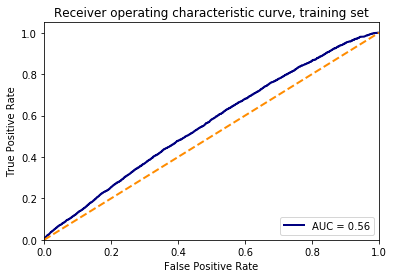

In [16]:
# Plot ROC curve for training set
probs_tr = pipe.predict_proba(X_train)
print (probs_tr)

auc_score_tr = metrics.roc_auc_score(y_train, probs_tr[:, 1])
fpr_tr, tpr_tr, thres_tr = metrics.roc_curve(y_train, probs_tr[:,1])

#Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr_tr, tpr_tr, color='navy',
         lw=lw, label='AUC = %0.2f' % auc_score_tr)
plt.plot([0, 1], [0, 1], color='darkorange', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve, training set')
plt.legend(loc="lower right")
plt.show()


In [7]:
print( metrics.confusion_matrix(y_test, predicted))
print( metrics.classification_report(y_test, predicted))
predicted_train = pipe.predict(X_train)
print( metrics.classification_report(y_train, predicted_train))

[[25117 30089]
 [  416   645]]
             precision    recall  f1-score   support

        0.0       0.98      0.45      0.62     55206
        1.0       0.02      0.61      0.04      1061

avg / total       0.97      0.46      0.61     56267

             precision    recall  f1-score   support

        0.0       0.98      0.46      0.62    220914
        1.0       0.02      0.63      0.04      4150

avg / total       0.97      0.46      0.61    225064



### Evaluate the model using 10-fold cross-validation


In [161]:
# scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=10)
recall = cross_val_score(pipe, X, y, cv=10, scoring='recall')

print (recall)
print (recall.mean())
print (recall.std())

# [ 0.59003831  0.61612284  0.61804223  0.68714012  0.62955854  0.60076775
#   0.61420345  0.57005758  0.59884837  0.61036468]
# 0.61351438804
# 0.0292113885642

# WITH ONLY LOGISTIC REGRESSION (NO Z-SCORE PREPROCESSING)
# [ 0.59195402  0.61612284  0.61804223  0.68714012  0.62955854  0.60076775
#   0.61420345  0.57005758  0.59884837  0.61036468]
# 0.613705958921
# 0.0290627055203

[ 0.59003831  0.61612284  0.61804223  0.68714012  0.62955854  0.60076775
  0.61420345  0.57005758  0.59884837  0.61036468]
0.61351438804
0.0292113885642


10-fold cross-validation gives consistent results (0.61 ± 0.03 highlight recall)

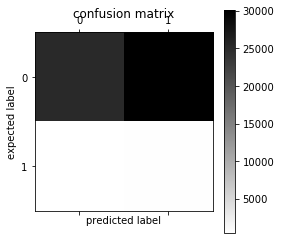

In [162]:
plt.matshow(confusion_matrix(y_test, predicted), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [169]:
# normalized confusion matrix values
cm = metrics.confusion_matrix(y_test, predicted)
print(cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(cm)

[[25117 30089]
 [  416   645]]
[[ 0.45496866  0.54503134]
 [ 0.39208294  0.60791706]]


In [103]:
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


In [104]:
# predict class labels for the test set
predicted = pipe.predict(X_test)
print(predicted)

# plt.matshow(confusion_matrix(X_test, predicted), cmap=plt.cm.binary, interpolation='nearest')
# plt.title('confusion matrix')
# plt.colorbar()
# plt.ylabel('expected label')
# plt.xlabel('predicted label')
# plt.show()

[ 1.  0.  1. ...,  1.  0.  1.]


### Inspect distribution of class probabilities



152825
37248


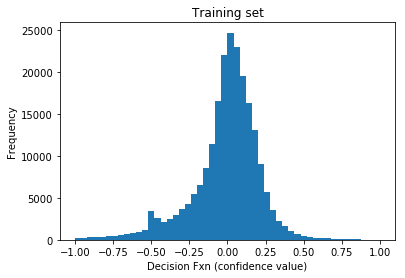

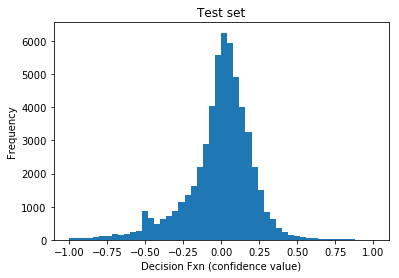

In [6]:
decfxn_tr = pipe.decision_function(X_train)
decfxn_ts = pipe.decision_function(X_test)
# print(decfxn_tr)
# print(decfxn_ts)
# print(min(decfxn_tr))
# print(min(decfxn_ts))
# print(max(decfxn_tr))
# print(max(decfxn_ts))

print(decfxn_tr.argmax())
print(decfxn_ts.argmax())


plt.hist(decfxn_tr, bins=50, range=(-1,1))#, normed=1)
plt.title("Training set")
plt.xlabel("Decision Fxn (confidence value)")
plt.ylabel("Frequency")
plt.show()

plt.hist(decfxn_ts, bins=50, range=(-1,1))#, normed=1)
plt.title("Test set")
plt.xlabel("Decision Fxn (confidence value)")
plt.ylabel("Frequency")
plt.show()



### Construct validation plots -- roc type curve for decision function value (confidence score)

Before computing the ROC curves shown above, I created a separate cumulative density function (CDF) plot by sorting the confidence scores of every sentence in the dataset by rank, then plotting the cumulative highlight recovery going down the ranks. This gave a similar result to the ROC curves, since moving along the x-axis of this CDF plot is similar to adjusting the confidence score threshold.

1061
[   71   102   110 ..., 56118 56203 56247]
4150
[    64    100    137 ..., 224889 224943 224996]
225064
4150.0
4150.0
[  1.00000000e+00   1.01843484e+00   1.03686968e+00 ...,   4.14996313e+03
   4.14998157e+03   4.15000000e+03]


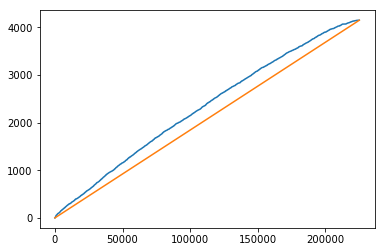

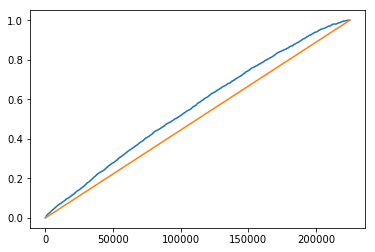

In [221]:
# sort common dataset by cosine similarity score
# plot cumulative density of highlights relative to cos similarity score
# if curve above 1:1 diagonal, means highlight prediction better than chance

# print(dataset_submit.head(10))
# print(dataset_submit.sort_values('LDAdist').head(10))
# print(dataset_submit.sort_values('LDAdist').tail(10))
# print(dataset_submit.sort_values('LDAdist').head(2000))



from scipy.interpolate import interp1d
# 
decfxn_tr
print(len(np.nonzero(y_test)[0]))
print(np.nonzero(y_test)[0])

print(len(np.nonzero(y_train)[0]))
print(np.nonzero(y_train)[0])

cumul = pd.DataFrame({'confidencescore':decfxn_tr, 'highlightornot':y_train})
cumul_sort = cumul.sort_values('confidencescore', ascending=False)
# print(cumul_sort)
total = 0
array = []
for i in cumul_sort['highlightornot']:
    total = total + i
    array.append(total)
# print(min(decfxn_tr))
print(len(array))
print(total)
print(array[-1])

# rangex = np.arange(1,4150)
line = np.linspace(1, 4150, 225064)
print(line)

# plot CDF curve and chance line
plt.plot(range(1,225065), array, range(1,225065), line)
plt.show()

# plot CDF curve and chance line, normalized
plt.plot(range(1,225065), array/max(array), range(1,225065), line/max(line))
plt.show()



### Define a function to draw CDF plots

In [14]:
def plot_cdf(decfxn, ytrain):
    cumul = pd.DataFrame({'confidencescore':decfxn, 'highlightornot':ytrain})
    cumul_sort = cumul.sort_values('confidencescore', ascending=False)
    # print(cumul_sort)
    total = 0
    array = []
    for i in cumul_sort['highlightornot']:
        array.append(total)
        total = total + i
    # print(min(decfxn_tr))
    print(len(array))
    print(total)
    print(array[-1])

    line = np.linspace(1, max(array), len(array))
#     print(line)

    # plot CDF curve and chance line
    plt.plot(range(1,len(array)+1), array, range(1,len(array)+1), line)
    plt.show()

    # plot CDF curve and chance line, normalized
    plt.plot(range(1,len(array)+1), array/max(array), range(1,len(array)+1), line/max(line))
    plt.show()
    
    normarray = array/max(array)
    
    print(sum(normarray)/(1*len(array)))

56267
1061.0
1061.0


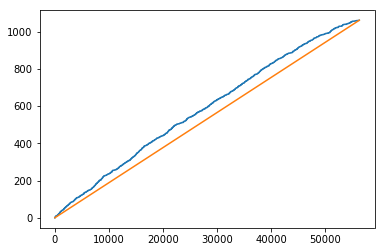

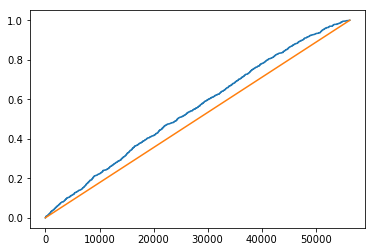

0.551621663421


In [9]:
plot_cdf(decfxn_ts, y_test)

## Test undersampling from imblearn for balancing class weights



In [113]:
# print original shape of y from above:
print('Original dataset shape {}'.format(Counter(y)))
undersample = RandomUnderSampler()
X_undersmp, y_undersmp = undersample.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_undersmp)))

Original dataset shape Counter({0.0: 276120, 1.0: 5211})
Resampled dataset shape Counter({1.0: 5211, 0.0: 5211})


In [117]:
# Split into train and test sets
X_undersmp_train, X_undersmp_test, y_undersmp_train, y_undersmp_test = \
train_test_split(X_undersmp, y_undersmp, test_size=0.2, random_state=0)

print('Resampled dataset shape {}'.format(Counter(y_undersmp_train)))
print('Resampled dataset shape {}'.format(Counter(y_undersmp_test)))

Resampled dataset shape Counter({1.0: 4203, 0.0: 4134})
Resampled dataset shape Counter({0.0: 1077, 1.0: 1008})


In [119]:
# Include data preprocessing to scale all features! (i.e. calculate z-scores)
pipe_undersmp = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', penalty='l2'))

# ## fit
# pipe.fit(X, y)
# ## predict
# pipe.predict_proba(X)
# ## to get back mean/std
# scaler = pipe.steps[0][1]
# scaler.mean_
# # Out[12]: array([ 0.0313, -0.0334,  0.0145, ..., -0.0247,  0.0191,  0.0439])
# scaler.std_
# # Out[13]: array([ 1.    ,  1.0553,  0.9805, ...,  1.0033,  1.0097,  0.9884])
    
    
# model = LogisticRegression(class_weight='balanced', penalty='l2')
pipe_undersmp.fit(X_undersmp_train, y_undersmp_train)
# print(X_train)
print(len(y_undersmp_train))
print(len(y_undersmp_test))
print(len(X_undersmp_train))
print(len(X_undersmp_test))



8337
2085
8337
2085


In [121]:
# # save model
# fpipe_undersmp = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/model_undersmp_len_lda_wpos_wpos_readmets','wb')
# pickle.dump(pipe_undersmp, fpipe_undersmp)

# load model
pipe_undersmp = pd.read_pickle('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/model_undersmp_len_lda_wpos_wpos_readmets')

# check the accuracy on the training set
print(pipe_undersmp.score(X_undersmp_train, y_undersmp_train))

# check the accuracy on the test set
print(pipe_undersmp.score(X_undersmp_test, y_undersmp_test))



0.548158810124
0.520383693046


In [124]:
# predict class labels for the test set
predicted_undersmp = pipe_undersmp.predict(X_undersmp_test)
print(predicted_undersmp)
test = np.nonzero(predicted_undersmp)
print(len(test[0]))
print(len(predicted_undersmp))

# examine the coefficients
print(np.transpose(pipe_undersmp.steps[1][1].coef_))
print(X_test.columns)

# generate class probabilities
probs_undersmp = pipe_undersmp.predict_proba(X_undersmp_test)
print (probs_undersmp)

# generate evaluation metrics
print( metrics.accuracy_score(y_undersmp_test, predicted_undersmp))
print( metrics.roc_auc_score(y_undersmp_test, probs_undersmp[:, 1]))

print( metrics.confusion_matrix(y_undersmp_test, predicted_undersmp))
print( metrics.classification_report(y_undersmp_test, predicted_undersmp))

# evaluate the model using 10-fold cross-validation
# scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=10)
recall_undersmp = cross_val_score(pipe_undersmp, X, y, cv=10, scoring='recall')

print (recall_undersmp)
print (recall_undersmp.mean())
print (recall_undersmp.std())

[ 1.  1.  1. ...,  0.  1.  0.]
1230
2085
[[ 0.        ]
 [-0.47851308]
 [-0.03087635]
 [ 0.0814741 ]
 [-0.03316393]
 [-0.01878615]
 [ 0.77610961]
 [ 1.01257391]
 [ 0.00578266]
 [ 0.12901553]
 [ 0.18632183]
 [ 0.07639077]
 [-0.37497635]]
Index(['Intercept', 'length', 'LDAdist', 'wordPos', 'sentPos', 'ARI', 'FRE',
       'FKG', 'GFI', 'SMG', 'CLI', 'LIX', 'RIX'],
      dtype='object')
[[ 0.4614495   0.5385505 ]
 [ 0.47152145  0.52847855]
 [ 0.4895365   0.5104635 ]
 ..., 
 [ 0.50380637  0.49619363]
 [ 0.47050047  0.52949953]
 [ 0.51401674  0.48598326]]
0.520383693046
0.540210350621
[[466 611]
 [389 619]]
             precision    recall  f1-score   support

        0.0       0.55      0.43      0.48      1077
        1.0       0.50      0.61      0.55      1008

avg / total       0.52      0.52      0.52      2085

[ 0.59003831  0.61612284  0.61804223  0.68714012  0.62955854  0.60076775
  0.61420345  0.57005758  0.59884837  0.61036468]
0.61351438804
0.0292113885642


In [127]:
# convert coefficients to probabilities
coeffs = np.transpose(pipe_undersmp.steps[1][1].coef_)
coeff_odds = []
coeff_probs = []
for i in coeffs:
    coeff_odds.append(math.exp(i))
    coeff_probs.append(math.exp(i)/(1+math.exp(i)))
    
print(coeff_odds)
print(coeff_probs)
print(X_test.columns)


[1.0, 0.6197041566997715, 0.9695954588907783, 1.0848851166868112, 0.9673799663533975, 0.981389206243711, 2.1730019841225814, 2.7526770590391414, 1.005799416639851, 1.137707793240735, 1.204809937231406, 1.0793842843468693, 0.687305531057032]
[0.5, 0.3826033008166441, 0.49228152639873957, 0.5203572647738275, 0.4917097779268677, 0.49530359969216464, 0.6848410416999703, 0.7335235661722391, 0.5014456621613655, 0.5322092181345262, 0.5464461661236404, 0.5190884111572007, 0.4073391086595096]
Index(['Intercept', 'length', 'LDAdist', 'wordPos', 'sentPos', 'ARI', 'FRE',
       'FKG', 'GFI', 'SMG', 'CLI', 'LIX', 'RIX'],
      dtype='object')


In [228]:
# normalized confusion matrix values
cm_undersmp = metrics.confusion_matrix(y_undersmp_test, predicted_undersmp)
print(cm_undersmp)
cm_undersmp = cm_undersmp.astype('float') / cm_undersmp.sum(axis=1)[:, np.newaxis]

print(cm_undersmp)

[[466 611]
 [389 619]]
[[ 0.43268338  0.56731662]
 [ 0.3859127   0.6140873 ]]


#### Generate CDF plots (see "Construct validation plots" section above)


8337
4203.0
4203.0


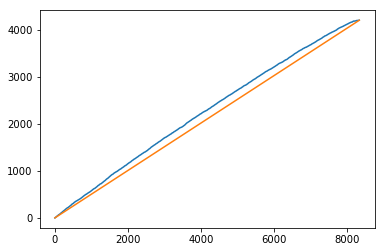

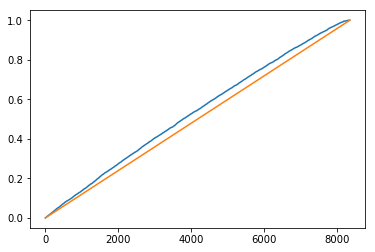

2085
1008.0
1008.0


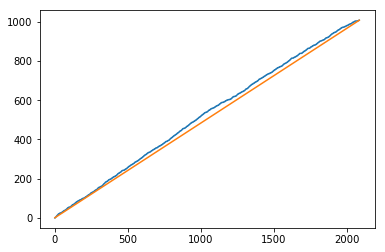

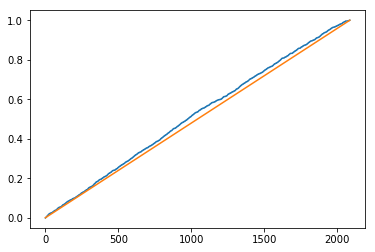

In [226]:
decfxn_tr_undersmp = pipe_undersmp.decision_function(X_undersmp_train)
decfxn_ts_undersmp = pipe_undersmp.decision_function(X_undersmp_test)

plot_cdf(decfxn_tr_undersmp, y_undersmp_train)
plot_cdf(decfxn_ts_undersmp, y_undersmp_test)

## Test SMOTE (synthetic oversampling) from imblearn for balancing class weights



In [4]:
# print original shape of y from above:
print('Original dataset shape {}'.format(Counter(y)))
smote = SMOTE()
X_smote, y_smote = smote.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_smote)))



Original dataset shape Counter({0.0: 276120, 1.0: 5211})
Resampled dataset shape Counter({1.0: 276120, 0.0: 276120})


In [5]:
# Split into train and test sets
X_smote_train, X_smote_test, y_smote_train, y_smote_test = \
train_test_split(X_smote, y_smote, test_size=0.2, random_state=0)

print('Resampled dataset shape {}'.format(Counter(y_smote_train)))
print('Resampled dataset shape {}'.format(Counter(y_smote_test)))



Resampled dataset shape Counter({0.0: 220917, 1.0: 220875})
Resampled dataset shape Counter({1.0: 55245, 0.0: 55203})


In [6]:
# Include data preprocessing to scale all features! (i.e. calculate z-scores)
pipe_smote = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', penalty='l2'))
    
pipe_smote.fit(X_smote_train, y_smote_train)
# print(X_train)
print(len(y_smote_train))
print(len(y_smote_test))
print(len(X_smote_train))
print(len(X_smote_test))



441792
110448
441792
110448


In [8]:
# save model
fpipe_smote = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/model_smote_len_lda_wpos_wpos_readmets','wb')
pickle.dump(pipe_smote, fpipe_smote)

# check the accuracy on the training set
print(pipe_smote.score(X_smote_train, y_smote_train))

# check the accuracy on the test set
print(pipe_smote.score(X_smote_test, y_smote_test))



0.539926028538
0.538561132841


In [11]:
# predict class labels for the test set
predicted_smote = pipe_smote.predict(X_smote_test)
print(predicted_smote)
test = np.nonzero(predicted_smote)
print(len(test[0]))
print(len(predicted_smote))

# examine the coefficients
print(np.transpose(pipe_smote.steps[1][1].coef_))
# print(X_smote_test.columns)

# generate class probabilities
probs_smote = pipe_smote.predict_proba(X_smote_test)
print (probs_smote)

# generate evaluation metrics
print( metrics.accuracy_score(y_smote_test, predicted_smote))
print( metrics.roc_auc_score(y_smote_test, probs_smote[:, 1]))

print( metrics.confusion_matrix(y_smote_test, predicted_smote))
print( metrics.classification_report(y_smote_test, predicted_smote))

# evaluate the model using 10-fold cross-validation
# scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=10)
recall_smote = cross_val_score(pipe_smote, X, y, cv=10, scoring='recall')

print (recall_smote)
print (recall_smote.mean())
print (recall_smote.std())

[ 0.  1.  1. ...,  1.  1.  1.]
63802
110448
[[ 0.        ]
 [-0.54720871]
 [ 0.00265248]
 [-0.07867989]
 [ 0.1102044 ]
 [-0.0438532 ]
 [ 0.59799881]
 [ 0.92154695]
 [-0.06256826]
 [ 0.1332407 ]
 [ 0.09715447]
 [ 0.17088002]
 [-0.58975695]]
[[ 0.52961794  0.47038206]
 [ 0.4179719   0.5820281 ]
 [ 0.49659791  0.50340209]
 ..., 
 [ 0.47521229  0.52478771]
 [ 0.4465655   0.5534345 ]
 [ 0.44269922  0.55730078]]
0.538561132841
0.556674374615
[[25442 29761]
 [21204 34041]]
             precision    recall  f1-score   support

        0.0       0.55      0.46      0.50     55203
        1.0       0.53      0.62      0.57     55245

avg / total       0.54      0.54      0.54    110448

[ 0.59003831  0.61612284  0.61804223  0.68714012  0.62955854  0.60076775
  0.61420345  0.57005758  0.59884837  0.61036468]
0.61351438804
0.0292113885642


In [12]:
# normalized confusion matrix values
cm_smote = metrics.confusion_matrix(y_smote_test, predicted_smote)
print(cm_smote)
cm_smote = cm_smote.astype('float') / cm_smote.sum(axis=1)[:, np.newaxis]

print(cm_smote)

[[25442 29761]
 [21204 34041]]
[[ 0.46088075  0.53911925]
 [ 0.38381754  0.61618246]]


#### Generate CDF plots (see "Construct validation plots" section above)


441792
220875.0
220875.0


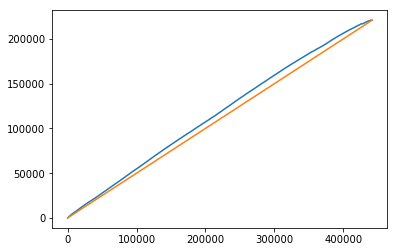

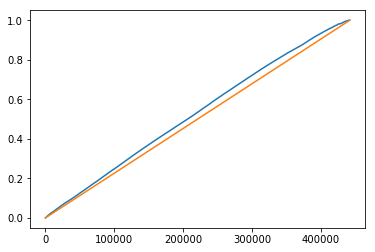

0.528512983291
110448
55245.0
55245.0


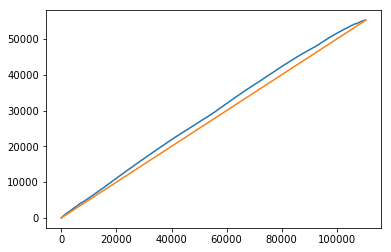

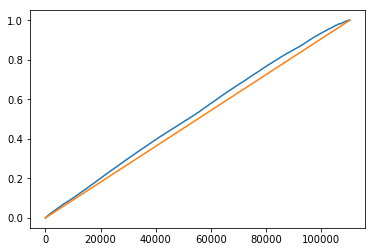

0.528321884524


In [15]:
decfxn_tr_smote = pipe_smote.decision_function(X_smote_train)
decfxn_ts_smote = pipe_smote.decision_function(X_smote_test)

plot_cdf(decfxn_tr_smote, y_smote_train)
plot_cdf(decfxn_ts_smote, y_smote_test)

### Conclusion from imblearn tests

I tested applying undersampling and synthetic oversampling (through the imblearn library) to the logistic regression and found that these methods achieved similar highlight recall (sensitivity, TP/(TP+FN)) but with more balanced precision and f1-scores between the highlighted and non-highlighted classes.

### TRY RANDOM FOREST with current features

I wanted to see whether a random forest model would be better than the logistic regression at classifying highlights. This was not my preferred method, since random forest models are generally less interpretable than logistic regression.

Here, I found that a random forest model attains a deceptively high overall accuracy, because it predicts almost all sentences to be non-highlighted, allowing the much bigger non-highlighted portion of the samples to overwhelm the prediction. Thus, I decided to stick with the logistic regression model.

In [170]:
from sklearn.ensemble import RandomForestClassifier

# # evaluate the model by splitting into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
modelRF = RandomForestClassifier(class_weight='balanced')
modelRF.fit(X_train, y_train)
# print(X_train)
print(len(y_train))
print(len(y_test))
print(len(X_train))
print(len(X_test))

225064
56267
225064
56267


In [171]:
print(modelRF)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [172]:
# save model
fmodelRF = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/modelRF_len_lda_wpos_wpos_readmets','wb')
pickle.dump(modelRF, fmodelRF)



In [173]:
# check the accuracy on the training set
print(modelRF.score(X_train, y_train))



0.994885899122


In [174]:
# check the accuracy on the test set
print(modelRF.score(X_test, y_test))



0.981143476638


In [175]:
# predict class labels for the test set
predictedRF = modelRF.predict(X_test)
print(predictedRF)

test = np.nonzero(predictedRF)
print(len(test[0]))
print(len(predictedRF))



[ 0.  0.  0. ...,  0.  0.  0.]
16
56267


In [176]:
# generate class probabilities
probsRF = modelRF.predict_proba(X_test)
print (probsRF)



[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [177]:
# generate evaluation metrics
print( metrics.accuracy_score(y_test, predictedRF))
print( metrics.roc_auc_score(y_test, probsRF[:, 1]))

print( metrics.confusion_matrix(y_test, predictedRF))
print( metrics.classification_report(y_test, predictedRF))



0.981143476638
0.519190098482
[[55198     8]
 [ 1053     8]]
             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99     55206
        1.0       0.50      0.01      0.01      1061

avg / total       0.97      0.98      0.97     56267



In [178]:
# evaluate the model using 10-fold cross-validation
recallRF = cross_val_score(modelRF, X, y, scoring='recall', cv=10)
print (recallRF)
print (recallRF.mean())
print (recallRF.std())

# Terrible highlight recall!
# [ 0.00383142  0.00191939  0.00767754  0.00191939  0.00575816  0.00959693
#   0.00575816  0.00575816  0.00383877  0.00575816]
# 0.00518160625381
# 0.00227957890199

[ 0.00383142  0.00191939  0.00767754  0.00191939  0.00575816  0.00959693
  0.00575816  0.00575816  0.00383877  0.00575816]
0.00518160625381
0.00227957890199


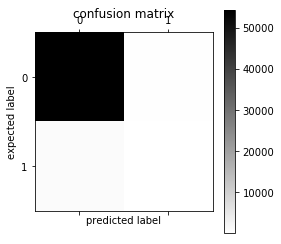

In [110]:
plt.matshow(confusion_matrix(y_test, predictedRF), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()